# Introduction to CNN (Convnet)

* Classify MNIST digits using a CNN
* Using a densely-connected network, the accuracy was around 98%


The code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)`.
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via
passing the argument `input_shape=(28, 28, 1)` to our first layer. `1` because of gray images that has only one channel. Note that this input shape is different from the 1st MNIST example using (28*28, ).

We will build the model using Functional API, not Sequential model. This problem is small enough to run without GPU.

In [15]:
# SEQUENTIAL MODEL
#
# from keras import layers
# from keras import models

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) # 32 - num of filters. Need to use input_shape for CNN, not dim.
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu')) # 64 => 32. Got better acc...
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [16]:
# FUNCTIONAL API that enables graph-like model architecture. See page 173
#
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)    # this line can be omitted
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network
looks like:

In [17]:
model.summary() # Let's display the architecture of our CNN

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,114 (652.79 KB)

 Trainable params: 167,114 (652.79 KB)

 Non-trainable params: 0 (0.00 B)

You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to
the `Conv2D` layers.

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor.
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from previous lecture.

In [18]:
from keras.datasets import mnist
#from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

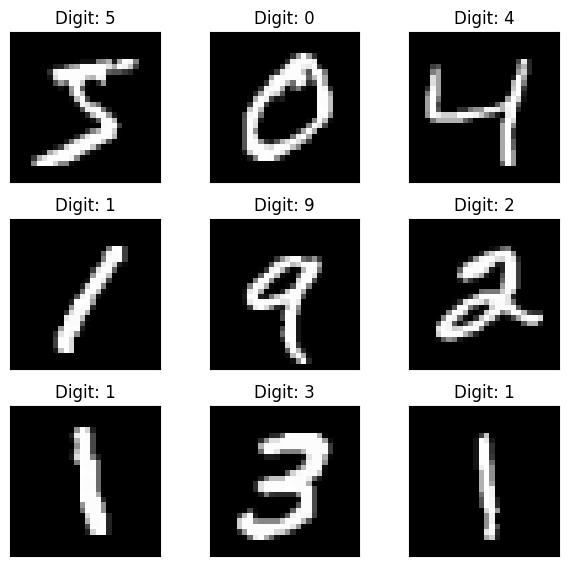

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(train_images[i], cmap='gray')
  #plt.imshow(train_images[i])
  plt.title(f"Digit: {train_labels[i]}")
  plt.xticks([])
  plt.yticks([])

In [20]:
train_images.shape

(60000, 28, 28)

In [21]:
train_images2 = train_images.reshape((60000, 28, 28, 1)) # 4D standard image shape
train_images2 = train_images2.astype('float32') / 255

test_images2 = test_images.reshape((10000, 28, 28, 1))
test_images2 = test_images2.astype('float32') / 255

#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)

In [22]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_images2, train_labels, epochs=5, batch_size=64,
                    validation_data=(test_images2, test_labels))           # using test images for validation

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8740 - loss: 0.3868 - val_accuracy: 0.9847 - val_loss: 0.0443
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9866 - loss: 0.0438 - val_accuracy: 0.9905 - val_loss: 0.0274
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9917 - loss: 0.0275 - val_accuracy: 0.9925 - val_loss: 0.0238
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9937 - loss: 0.0208 - val_accuracy: 0.9930 - val_loss: 0.0241
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9951 - loss: 0.0152 - val_accuracy: 0.9925 - val_loss: 0.0254


In [23]:
print(history.history)
print(history.history.keys())

{'accuracy': [0.9492499828338623, 0.9871166944503784, 0.9913666844367981, 0.9939833283424377, 0.9949166774749756], 'loss': [0.16053014993667603, 0.041700638830661774, 0.028700387105345726, 0.019946744665503502, 0.015660343691706657], 'val_accuracy': [0.9847000241279602, 0.9904999732971191, 0.9925000071525574, 0.9929999709129333, 0.9925000071525574], 'val_loss': [0.044256262481212616, 0.027427542954683304, 0.02383502572774887, 0.024121148511767387, 0.025387702509760857]}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Let's plot graphs to see if overfitting occured. We used unseen test dataset for validation in the fit() method above.

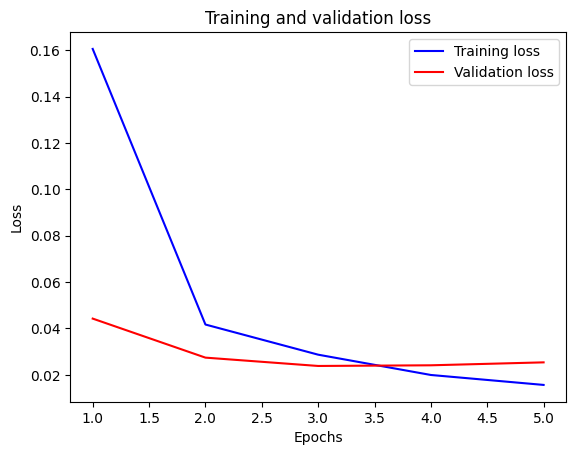

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

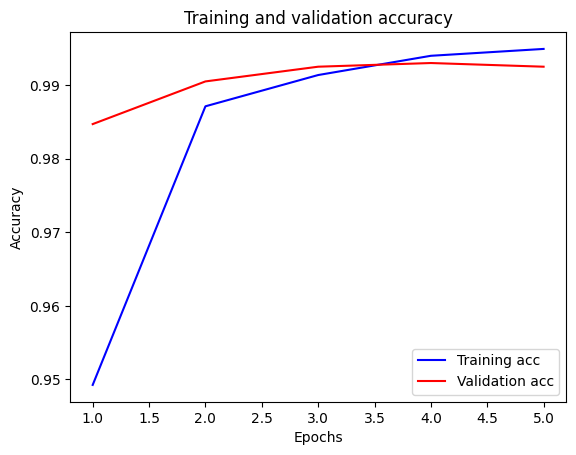

In [25]:
plt.clf()   # clear figure
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The above two graphs do not show the evidence of overfitting.

Let's evaluate the model on the test data:

In [26]:
test_loss, test_acc = model.evaluate(test_images2, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9905 - loss: 0.0327


While our densely-connected neural network (DNN) from previous lecture had a test accuracy of 97.8%, our basic CNN has a test accuracy of 99.3%: Our error rate was also decreased from 0.07 to 0.02.

By the way, **If you do not get 99% test accuracy, run again.**

## Now let's test a test image, test_images[88]

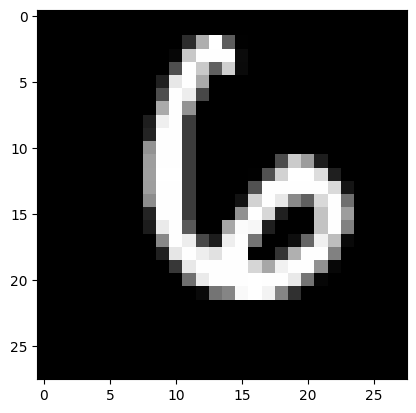

In [27]:
plt.figure()
plt.imshow(test_images[88], cmap='gray', interpolation='none') # need to use original data to display

In [28]:
import numpy as np
np.argmax(model.predict(np.array([test_images2[88]])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


np.int64(6)